# Librerias

In [1]:
pip install Keras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Geo Headmaps
import plotly.express as px

#Escalado de Datos
from sklearn.preprocessing import StandardScaler

#Polynomial
from sklearn.preprocessing import PolynomialFeatures

#Modelo Benchmark
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Models
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import VotingRegressor
from mlxtend.regressor import StackingRegressor


#Metricas 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Rede neuronales
import tensorflow as tf
from sklearn.neural_network import MLPRegressor

from sklearn import  metrics
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
url = '/content/drive/MyDrive/Data/properati.csv'
data = pd.read_csv(url)

In [4]:
def valores_nulos(dataset):
  print('<------------->')
  print('Porcentaje de Valores nulos\n')
  print(dataset.isnull().sum() / dataset.shape[0] * 100)

https://medium.com/@manilwagle/predicting-house-prices-using-machine-learning-cab0b82cd3f

https://towardsdatascience.com/predicting-house-prices-with-linear-regression-machine-learning-from-scratch-part-ii-47a0238aeac



# Filtrado de Información

Empleo los mismo filtros de información solicitados desde el proyecto 1.

In [5]:
data_ml=data[(data.l2 == 'Capital Federal') & (data.property_type.isin(['Departamento', 'Casa', 'PH']))]
data_ml = data_ml[(data_ml.surface_total >= 15)] 
data_ml = data_ml[(data_ml.surface_total <= 1000)]
data_ml = data_ml[(data_ml.price <= 4000000 )]
data_ml = data_ml[['lat', 'lon','l3','property_type','rooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']]

In [6]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

lat                5.175239
lon                5.175239
l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.068311
surface_total      0.000000
surface_covered    0.627633
price              0.000000
dtype: float64


In [7]:
#¿Presencia de valores invertidos?
datos_invertidos= data_ml.loc[data_ml.surface_total < data_ml.surface_covered]
print('Existen', len(datos_invertidos),'datos invertidos')

Existen 751 datos invertidos


Ya que no cuento con información que respalde que los usuarios realizaron un mal llenado de los datos en la plataforma, introduciendo los datos acerca de superficie cubierta en el campo correspondiente a superficie total. Por lo que en la data, se encuentran valores de superficie cubierta mayores a superficie total.
Ya que estos datos no representan un gran porcentaje de datos, decidido eliminarlos.


In [8]:
#Limpieza de valores invertidos
data_ml = data_ml[(data_ml.surface_total >= data_ml.surface_covered)]

In [9]:
#Comprobación 
datos_invertidos_2= data_ml.loc[data_ml.surface_total < data_ml.surface_covered]
print('Existen', len(datos_invertidos_2),'datos invertidos')

Existen 0 datos invertidos


In [10]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

lat                5.240121
lon                5.240121
l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.022132
surface_total      0.000000
surface_covered    0.000000
price              0.000000
dtype: float64


Al eliminar la información correspondiente a valores invertidos, la presencia de valores nulos disminuye


In [11]:
#Eliminar informacion duplicada
data_ml.drop_duplicates(inplace=True)

In [12]:
#Copia
data_py2 = data_ml.copy()

#EDA

## Imputación de Valores faltantes

Para la imputación de valores faltantes, decido emplear la media correspondientes a los baños en función del tipo de propiedad.
Por lo que empleo mi dataset copia para obtener la media y así poder imputar en mis data de trabajo.


In [13]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

lat                5.504110
lon                5.504110
l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.418028
surface_total      0.000000
surface_covered    0.000000
price              0.000000
dtype: float64


In [14]:
#Elimino valores nulos en dataset copia
data_py2.dropna(inplace=True)

In [15]:
#Agrupación segun el tipo de propiedad
mean_bt = data_py2.groupby('property_type')['bathrooms'].mean().round(0)

In [16]:
mean_bt = dict(round(mean_bt))
mean_bt

{'Casa': 2.0, 'Departamento': 2.0, 'PH': 1.0}

In [17]:
#Imputar valores
data_ml.bathrooms = data_ml.bathrooms.fillna(data_ml.property_type.map(mean_bt))

In [18]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

lat                5.50411
lon                5.50411
l3                 0.00000
property_type      0.00000
rooms              0.00000
bathrooms          0.00000
surface_total      0.00000
surface_covered    0.00000
price              0.00000
dtype: float64


# Análisis Data

###Departamentos

In [19]:
data_geo = data_ml.copy()
data_geo.dropna(axis=0, inplace=True)
data_geo.reset_index(drop=True, inplace=True)

In [20]:
#Filtro exclusivo para datos de Departamentos
data_departamentos = data_geo[data_geo['property_type'] == 'Departamento']

In [21]:
px.set_mapbox_access_token("pk.eyJ1IjoibmVzdG9yanIiLCJhIjoiY2tqeWp1ZnA0MDEzdjJwcWthOHloOWZ2diJ9.Gb5H_uqHOuk3vxxJPIpf0w")

In [22]:
fig = px.scatter_mapbox(data_departamentos,
                        lat="lat",
                        lon="lon",
                        color="l3",
                        hover_name="property_type",
                        size="price",
                        hover_data=["price", "l3"],
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

El gráfico, ayuda a una mejor comprensión de la ubicación de las propiedades en función de los barrios. Ya que si las personas  desean estudiar los datos y estas no son  de la región. les resulta algo confuso la ubicación de los barrios. Por lo que este gráfico ayuda a una mejor comprensión además de mostrar los barrio con mayores registros



In [23]:
fig = px.scatter_mapbox(data_departamentos,
                        lat="lat",
                        lon="lon",
                        color="price",
                        hover_name="l3",
                        size="price",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

A partir del gráfico, se evidencia que los Departamentos con los precios más altos, son los que presentan mayor cercanía al mar. Teniendo diferentes variables que posiblemente afectan el precio como lo es la cercanía al puerto, Aeropuerto, parques, campos de golf y plazas comerciales.

In [24]:
#Precio por metro cuadrado de las viviendad
data_departamentos['price_m2'] = (data_departamentos['price'] / data_departamentos['surface_total']).round(2)

In [25]:
z = data_departamentos.l3.value_counts().head(10)
print('Regiones con mas registros de Departamentos')
for i in z.index:
  print('--> {}'.format(i))

Regiones con mas registros de Departamentos
--> Palermo
--> Belgrano
--> Recoleta
--> Caballito
--> Almagro
--> Villa Crespo
--> Villa Urquiza
--> Barrio Norte
--> Flores
--> Balvanera


In [26]:
j = data_departamentos.price.value_counts().head(10)
print('Precios mas frecuentes en Departamentos')
for i in j.index:
  print('--> ${}'.format(i))

Precios mas frecuentes en Departamentos
--> $125000.0
--> $120000.0
--> $115000.0
--> $135000.0
--> $110000.0
--> $145000.0
--> $165000.0
--> $130000.0
--> $95000.0
--> $105000.0


In [27]:
m2_price = data_departamentos.price_m2.sort_values(ascending=False).head(10)
print('Precio por metro cuadrado mas elevados')
for i in range(10):
  print('--> ${}'.format(m2_price.iloc[i]))

Precio por metro cuadrado mas elevados
--> $58333.33
--> $39632.93
--> $22222.22
--> $22200.0
--> $20491.8
--> $20202.02
--> $14787.23
--> $14666.67
--> $14255.32
--> $14084.54


In [28]:
#Datos de propieades con mayor precio por metro cuadrado
data_departamentos.loc[[12934,41108,26882,6808,7053,42863,30986,17521,30983,16226]]

lat        lon  ...      price  price_m2
12934 -34.609558 -58.362674  ...  3150000.0  58333.33
41108 -34.593645 -58.399170  ...  3249900.0  39632.93
26882 -34.630894 -58.408096  ...  1000000.0  22222.22
6808  -34.633503 -58.453378  ...  1110000.0  22200.00
7053  -34.581464 -58.426407  ...  1250000.0  20491.80
42863 -34.688740 -58.477428  ...  1111111.0  20202.02
30986 -34.610849 -58.361958  ...  1390000.0  14787.23
17521 -34.610576 -58.361591  ...  1100000.0  14666.67
30983 -34.610849 -58.361958  ...  1340000.0  14255.32
16226 -34.575802 -58.404921  ...  3000007.0  14084.54

[10 rows x 10 columns]

###Casa

In [29]:
data_casa = data_geo[data_geo['property_type'] == 'Casa']

In [30]:
fig = px.scatter_mapbox(data_casa,
                        lat="lat",
                        lon="lon",
                        color="l3",
                        hover_name="property_type",
                        size="price",
                        hover_data=["price", "l3"],
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000,)
fig.update_layout(mapbox_style="dark")
fig.show()

De igual manera, el gráfico ayuda a una mejor comprensión de la dispersión de los datos, mostrando los barrios con mayor registros y la ubicación exacta de las propiedades registradas

In [31]:
fig = px.scatter_mapbox(data_casa,
                        lat="lat",
                        lon="lon",
                        color="price",
                        hover_name="l3",
                        size="price",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

A diferencia de los departamentos, las casas presentan precios más equilibrados entre sí, siendo las casas más caras las que se encuentran con mayor cercanía al mar, dando mayor plusvalía la cercanía a parques, puertos,club de golf, plazas comerciales …

In [32]:
#Precio por metro cuadrado de la vivienda
data_casa['price_m2'] = (data_casa['price'] / data_casa['surface_total']).round(2)

In [33]:
z = data_casa.l3.value_counts().head(10)
print('Regiones con mas registros de Casas')
for i in z.index:
  print('--> {}'.format(i))

Regiones con mas registros de Casas
--> Villa Devoto
--> Flores
--> Mataderos
--> Villa Lugano
--> Caballito
--> Belgrano
--> Villa del Parque
--> Villa Urquiza
--> Parque Chacabuco
--> Nuñez


In [34]:
j = data_casa.price.value_counts().head(10)
print('Precios mas frecuentes en Casa')
for i in j.index:
  print('--> ${}'.format(i))

Precios mas frecuentes en Casa
--> $250000.0
--> $350000.0
--> $320000.0
--> $260000.0
--> $280000.0
--> $450000.0
--> $220000.0
--> $420000.0
--> $180000.0
--> $330000.0


In [35]:
m2_price = data_casa.price_m2.sort_values(ascending=False).head(10)
print('Precio por metro cuadrado mas elevados')
for i in range(10):
  print('--> ${}'.format(m2_price.iloc[i]))

Precio por metro cuadrado mas elevados
--> $6000.0
--> $5000.0
--> $4916.67
--> $4545.45
--> $4304.64
--> $4281.77
--> $4248.21
--> $4241.83
--> $4225.35
--> $4083.33


In [36]:
#Datos de propieades con mayor precio por metro cuadrado
data_casa.loc[[39798,28320,30010,4275,41128,16047,38749,34258,9981,22428]]

lat        lon          l3  ... surface_covered      price  price_m2
39798 -34.576885 -58.401905     Palermo  ...           192.0  1200000.0   6000.00
28320 -34.577053 -58.413982     Palermo  ...           300.0  1500000.0   5000.00
30010 -34.568165 -58.441872    Belgrano  ...           550.0  2950000.0   4916.67
4275  -34.570165 -58.462383    Belgrano  ...           880.0  4000000.0   4545.45
41128 -34.642143 -58.510571     Liniers  ...           151.0   650000.0   4304.64
16047 -34.592067 -58.415244     Palermo  ...           362.0  1550000.0   4281.77
38749 -34.622993 -58.421955       Boedo  ...            56.0   237900.0   4248.21
34258 -34.571346 -58.447880    Belgrano  ...           153.0   649000.0   4241.83
9981  -34.559151 -58.481935       Nuñez  ...           290.0  1500000.0   4225.35
22428 -34.573823 -58.455261  Colegiales  ...            61.0   318500.0   4083.33

[10 rows x 10 columns]

###PH

In [37]:
data_ph = data_geo[data_geo['property_type'] == 'PH']

In [38]:
fig = px.scatter_mapbox(data_ph,
                        lat="lat",
                        lon="lon",
                        color="l3",
                        hover_name="property_type",
                        size="price",
                        hover_data=["price", "l3"],
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

La presencia de registros de PH, se encuentra con buena dispersion por toda la Capital Federal

In [39]:
fig = px.scatter_mapbox(data_ph, 
                        lat="lat",
                        lon="lon",
                        color="price",
                        hover_name="l3",
                        size="price",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

Los precios de los penthouse registrados no se presentan tan disparados como lo es en el caso de los Departamentos. Teniendo pocos registros de Penthouse elevados en función de la cercanía al mar.

In [40]:
#Precio por metro cuadrado de la vivienda
data_ph['price_m2'] = (data_ph['price'] / data_ph['surface_total']).round(2)

In [41]:
z = data_ph.l3.value_counts().head(10)
print('Regiones con mas registros de Penthouse')
for i in z.index:
  print('--> {}'.format(i))

Regiones con mas registros de Penthouse
--> Caballito
--> Palermo
--> Villa Urquiza
--> Villa Devoto
--> Almagro
--> Villa Crespo
--> Flores
--> Villa del Parque
--> Floresta
--> Saavedra


In [42]:
j = data_ph.price.value_counts().head(10)
print('Precios mas frecuentes en Penthouse')
for i in j.index:
  print('--> ${}'.format(i))

Precios mas frecuentes en Penthouse
--> $120000.0
--> $150000.0
--> $175000.0
--> $130000.0
--> $110000.0
--> $220000.0
--> $125000.0
--> $145000.0
--> $155000.0
--> $250000.0


In [43]:
m2_price = data_ph.price_m2.sort_values(ascending=False).head(10)
print('Precio por metro cuadrado mas elevados')
for i in range(10):
  print('--> ${}'.format(m2_price.iloc[i]))

Precio por metro cuadrado mas elevados
--> $5557.69
--> $5322.58
--> $5151.52
--> $5000.0
--> $4903.85
--> $4852.94
--> $4743.59
--> $4487.18
--> $4421.05
--> $4348.84


In [44]:
#Datos de propieades con mayor precio por metro cuadrado
data_ph.loc[[47064,36912,36997,8898,31073,8383,24384,8930,25011,1372]]

lat        lon            l3  ... surface_covered     price  price_m2
47064 -34.582045 -58.469325   Parque Chas  ...            44.0  289000.0   5557.69
36912 -34.579309 -58.430957       Palermo  ...            50.0  330000.0   5322.58
36997 -34.599532 -58.391948  Barrio Norte  ...            33.0  170000.0   5151.52
8898  -34.577070 -58.439040       Palermo  ...           118.0  590000.0   5000.00
31073 -34.598020 -58.500930  Villa Devoto  ...            52.0  255000.0   4903.85
8383  -34.584160 -58.441956       Palermo  ...            34.0  165000.0   4852.94
24384 -34.585613 -58.437803       Palermo  ...            39.0  185000.0   4743.59
8930  -34.585613 -58.437803       Palermo  ...            39.0  175000.0   4487.18
25011 -34.559519 -58.481781       Coghlan  ...            75.0  420000.0   4421.05
1372  -34.588977 -58.390592      Recoleta  ...            35.0  187000.0   4348.84

[10 rows x 10 columns]

### Similitud en propiedades

Text(0.5, 1.0, 'Relacion de tipos de propiedad')

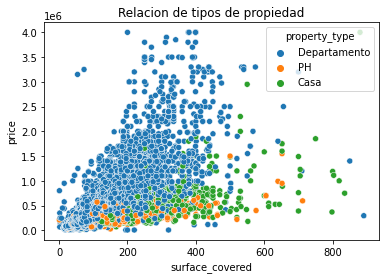

In [45]:
sns.scatterplot(data=data_ml, x='surface_covered', y='price', hue='property_type')
plt.title('Relacion de tipos de propiedad')

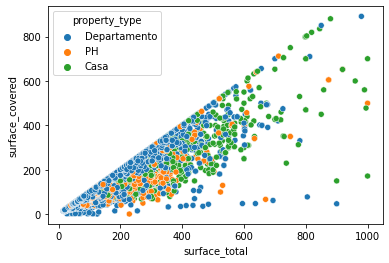

In [46]:
sns.scatterplot(x='surface_total', y='surface_covered', data=data_ml, hue='property_type')

Con base en ambos gráficos presentados, existe una similitud entre los tres tipos de propiedad (Casa, Departamento y PH). No se logra una completa diferenciación en el precio si la propiedad es un departamento, casa o penthouse. Por lo que `property_type` no es una variable completamente dependiente del precio de la propiedad.

Al graficar la superficie cubierta y el precio de la propiedad, se logra una mejor distinción del tipo de propiedad, Siendo Casa y PH las que presentan mayor similitud.

Al `Surface_total` y `Surface_covered` se presenta la misma problemática, en donde se presenta similitud entre los registros de Casa y PH


#Modelo Benchmark

In [47]:
#Defino la formula de mi regresion para predecir el precio
reg = smf.ols('price ~ rooms + bathrooms + surface_total + surface_covered', data= data_ml)

In [48]:
#Entreno el modelo
res = reg.fit()

In [49]:
#Informe
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 1.941e+04
Date:                Fri, 15 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:24:59   Log-Likelihood:            -6.7715e+05
No. Observations:               49999   AIC:                         1.354e+06
Df Residuals:                   49994   BIC:                         1.354e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.241e+04   2244.095     

Dado el informe del modelo, las métricas globales para la regresión lineal aplicada, obtuvo un R2 de 0.6.
Esta métrica es más baja que la obtenida en el proyecto 2. 
Ya que en el proyecto 2 en mi modelo final seleccionado `Ridge` obtuve un valor de R2 de 0.77.
Por lo que estos dos valores de mi modelo Benchmark y el modelo del proyecto 2, serán las referencias a superar



# Aumento de Correlación

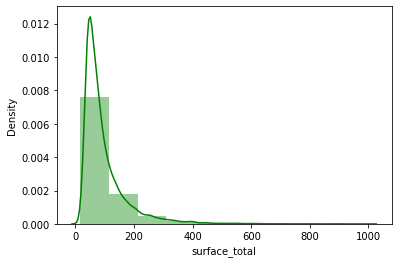

In [50]:
sns.distplot(data_ml.surface_total,
             kde=True,
             color='green',
             bins=10)

Ya que los datos de superficie total , presentan asimetría. Además de presentar varios valores atípicos, y estos afectan directamente al rendimiento del modelo.


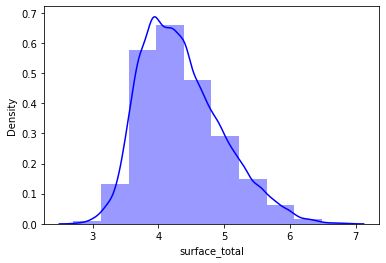

In [51]:
sns.distplot(np.log(data_ml.surface_total), 
             kde=True, 
             color='blue',
             bins=10)

Aplico logaritmo a los datos con el fin de modificar la simetría y como consecuencia los outlier reduzcan.

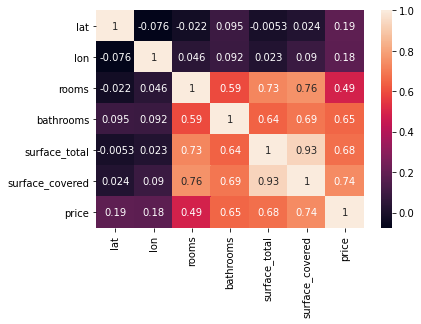

In [52]:
sns.heatmap(data_ml.corr(), annot=True)

Correlación de variables.
En donde rooms es la variable que presenta menor relación, por lo que es de considerarse descartarla.

In [53]:
columnas = ['rooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']

for i in columnas:
  data_ml[i]= data_ml[i].map(np.log)

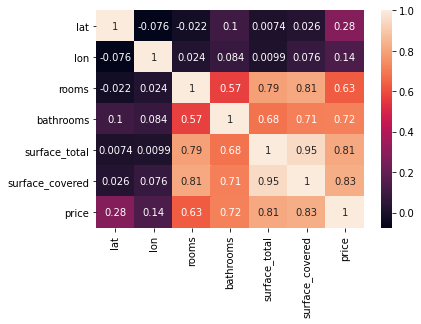

In [54]:
sns.heatmap(data_ml.corr(), annot=True)

Al aplicar logaritmo a las variables, su correlación aumenta. Siendo Room la que se ve más favorecida.

https://github.com/traintestbritt/predicting_house_prices/blob/master/notebook-house_price_predictions-brittany_allen.ipynb

#Divison Datos X e Y

In [55]:
#Separo datos en X e Y
X = data_ml[['rooms', 'bathrooms', 'surface_total', 'surface_covered']]
Y = data_ml[['price']]

In [56]:
X.shape, Y.shape

((49999, 4), (49999, 1))

# Polynomial Features

In [57]:
poly = PolynomialFeatures(degree=4)

In [58]:
features_poly = poly.fit_transform(X)

In [59]:
poly_df = pd.DataFrame(features_poly, columns=poly.get_feature_names())

In [60]:
poly_df.head(2)

1        x0        x1  ...   x2^2 x3^2     x2 x3^3        x3^4
0  1.0  1.945910  0.693147  ...  596.328089  596.328089  596.328089
1  1.0  0.693147  0.693147  ...  297.589163  284.416897  271.827679

[2 rows x 70 columns]

In [61]:
poly_df.shape

(49999, 70)

# Escalado de Datos

In [62]:
#Defino el modelo
std = StandardScaler()

In [63]:
#Entreno modelo
std.fit(poly_df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [64]:
#Transformo datos
data_escalada = std.transform(poly_df)

In [65]:
#Conversion a DataFramde
data_escalada = pd.DataFrame(data_escalada)

#Enconding

In [66]:
#Selecciono datos de barrios
l3 = data_ml['l3']

In [67]:
l3_get = pd.get_dummies(l3, prefix=('x'))

In [68]:
#Reseteo Index
data_escalada.reset_index(drop=True, inplace=True)
l3_get.reset_index(drop=True, inplace=True)

In [69]:
poly_df.shape, l3_get.shape

((49999, 70), (49999, 57))

In [70]:
#Union de DataFrames
data_eda = pd.merge(poly_df, l3_get, how='left', left_index=True, right_index=True)

#Modelos

In [71]:
#Division datos entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(data_eda, Y,
                                                    test_size=0.25,
                                                    random_state=40)

In [72]:
def evaluar_modelo(modelo,X_train,X_test,y_train,y_test):
    modelo.fit(X_train,y_train)
    print ("* R2 del modelo  en train:", modelo.score(X_train,y_train) )
    print('RMSE en train:',np.sqrt(mean_squared_error(y_train, modelo.predict(X_train))))
    print ("* R2 del modelo en test:", modelo.score(X_test,y_test) )
    print('RMSE en test:',np.sqrt(mean_squared_error(y_test, modelo.predict(X_test))))

In [73]:
def graficos_prediccion(modelo):
  y_pred = modelo.predict(X_test)
  sns.distplot(y_test, kde=False, color='red', bins=50, label='Real price')
  sns.distplot(y_pred, kde=False, color='blue', bins=50, label='Predict price')
  
  plt.xlabel('Sale Price', fontsize=19, labelpad=11)
  plt.xticks(fontsize=14)
  plt.ylabel('Count', fontsize=19, labelpad=11)
  plt.yticks(fontsize=14)
  plt.legend(loc='upper right');

In [74]:
def graficos_error(model):

  #Grafico de error
  y_train_pred_1 = model.predict(X_train)
  y_test_pred_1 = model.predict(X_test)
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_1))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_1))
  plt.figure(figsize = (10,6))
  plt.subplot(1,2,1)
  sns.distplot(y_train - y_train_pred_1, bins = 20, label = 'train')
  sns.distplot(y_test - y_test_pred_1, bins = 20, label = 'test')
  plt.xlabel('errores')
  plt.legend()
  
  #Comparativa predicciones
  plt.subplot(1,2,2)
  sns.distplot(y_test, kde=False, color='red', bins=50, label='Real price')
  sns.distplot(y_test_pred_1, kde=False, color='blue', bins=50, label='Predict price')
  plt.xlabel('Sale Price')
  plt.xticks(fontsize=14)
  plt.ylabel('Count')
  plt.legend(loc='upper right')

In [75]:
def get_random_sample(model, numero_muestra):
  
  #Tomo una muestra de mis datos en Test
  idxs = np.random.randint(X_test.shape[0], size=numero_muestra)

  muestra = X_test.iloc[idxs]
  prediccion = model.predict(muestra)

  valor_data = []
  for i in idxs:
    valor_real = y_test.price.iloc[i]
    valor_data.append(valor_real)

  valor_data = pd.DataFrame((valor_data), columns = ['valor_real'])
  prediccion = pd.DataFrame((prediccion), columns = ['valor_predicho'])
  comparacion = pd.merge(valor_data, prediccion, right_index=True, left_index=True)

  #Grafico
  r = comparacion['valor_real']
  p = comparacion['valor_predicho']
  plt.figure(figsize=(15,4))
  plt.plot(r,'o-',label='Valores reales')
  plt.plot(p,'o-',label='Valores predichos')
  plt.legend()
  plt.title('Comparacion de valores de propiedad')
  plt.xlabel('Muestra')
  plt.ylabel('Precio')

In [76]:
def graficos(model,X_test,y_test):
    y_pred = model.predict(X_test)
    
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    sns.distplot(y_pred, label='Predicciones')
    sns.distplot(y_test, label='Valor real')
    plt.legend()

    plt.subplot(1,2,2)
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

In [ ]:
break

##LinearRegression

In [77]:
linear = LinearRegression()

In [78]:
evaluar_modelo(linear, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.8689272098825236
RMSE en train: 0.2504201067521666
* R2 del modelo en test: 0.862227892311509
RMSE en test: 0.255588126282644


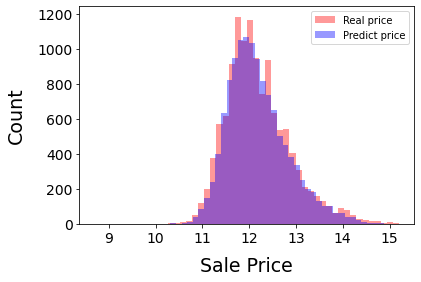

In [79]:
graficos_prediccion(linear)

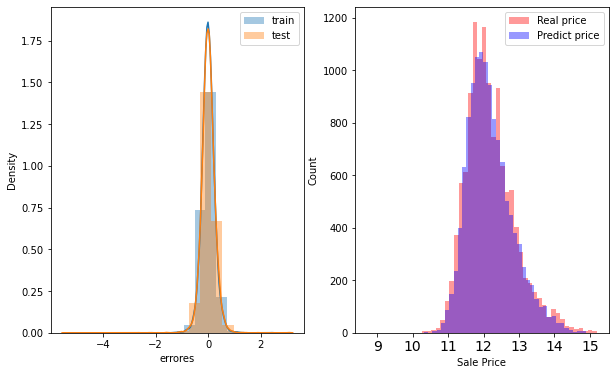

In [80]:
graficos_error(linear)

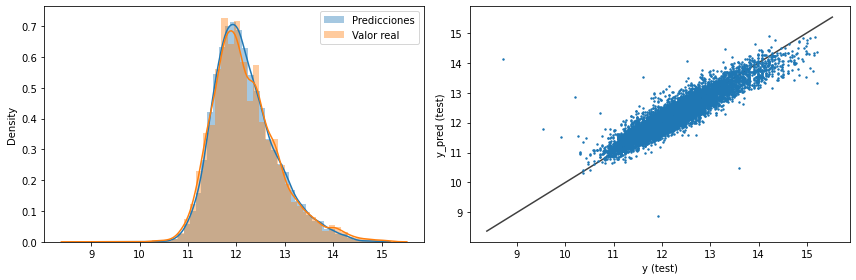

In [81]:
graficos(linear, X_test, y_test)

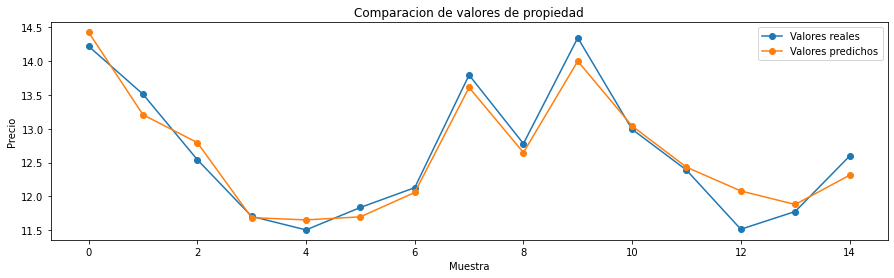

In [82]:
get_random_sample(linear, 15)

##RidgeCV

In [83]:
ridge = RidgeCV()

In [84]:
evaluar_modelo(ridge, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.867290709015414
RMSE en train: 0.251978559397592
* R2 del modelo en test: 0.8625886800809918
RMSE en test: 0.2552532489226147


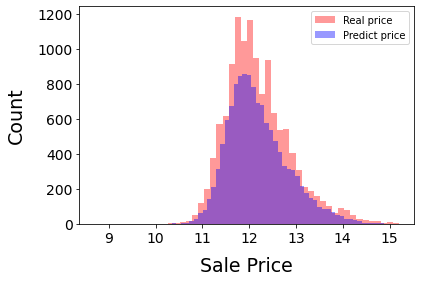

In [85]:
graficos_prediccion(ridge)

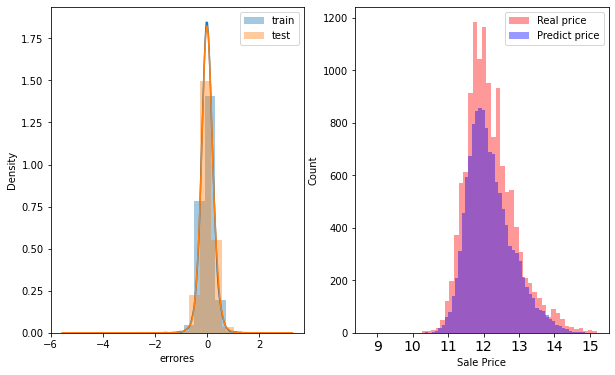

In [86]:
graficos_error(ridge)

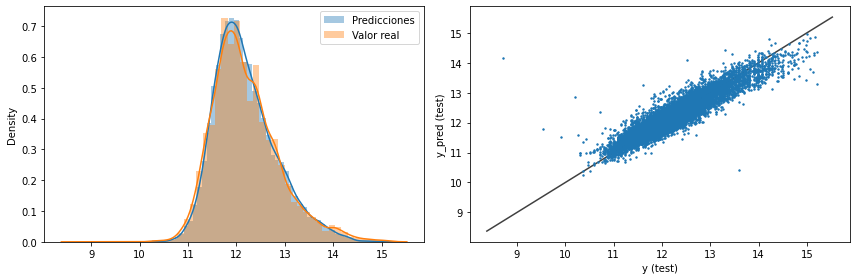

In [87]:
graficos(ridge, X_test, y_test)

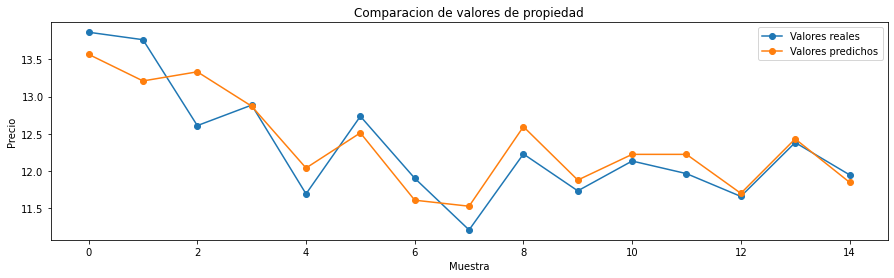

In [88]:
get_random_sample(ridge, 15)

##LassoCV

In [89]:
lasso = LassoCV()

In [90]:
evaluar_modelo(lasso, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.7469566350877441
RMSE en train: 0.3479448407579459
* R2 del modelo en test: 0.7469553452928123
RMSE en test: 0.3463846250854552


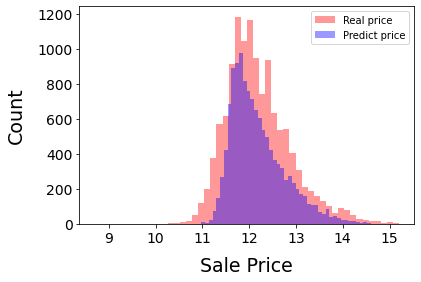

In [91]:
graficos_prediccion(lasso)

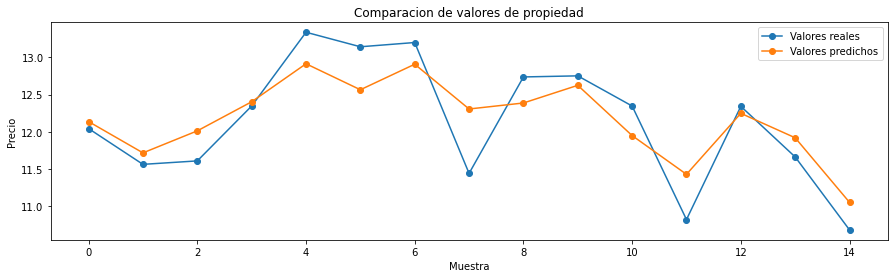

In [92]:
get_random_sample(lasso, 15)

##GradientBoostingRegressor

In [93]:
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

In [94]:
evaluar_modelo(clf, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.9104051962402411
RMSE en train: 0.2070400364753905
* R2 del modelo en test: 0.8793476077859674
RMSE en test: 0.2391817238039743


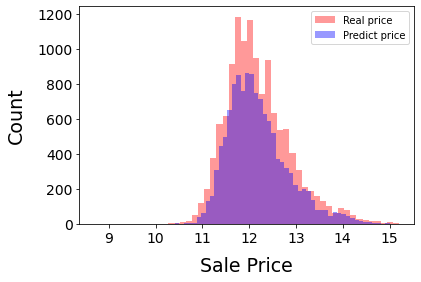

In [95]:
graficos_prediccion(clf)

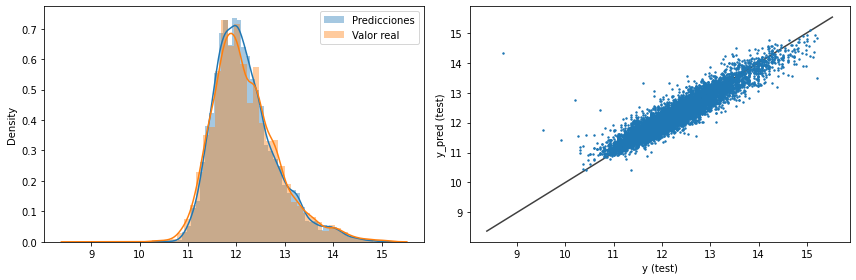

In [96]:
graficos(clf, X_test, y_test)

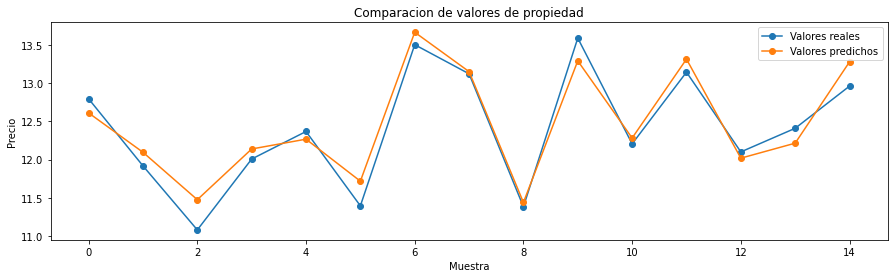

In [97]:
get_random_sample(clf, 15)

##SVR

In [ ]:
super_regresor = SVR()

In [ ]:
evaluar_modelo(super_regresor, X_train, X_test, y_train, y_test)

In [ ]:
graficos_prediccion(super_regresor)

In [ ]:
get_random_sample(super_regresor, 15)

##ExtraTreesRegressor

In [ ]:
tree_reg = ExtraTreesRegressor(n_estimators=100, random_state=40)

In [ ]:
evaluar_modelo(tree_reg, X_train, X_test, y_train, y_test)

In [ ]:
graficos_prediccion(tree_reg)

In [ ]:
graficos(tree_reg, X_test, y_test)

In [ ]:
get_random_sample(tree_reg, 15)

##BayesianRidge

In [ ]:
bay_reg = linear_model.BayesianRidge()

In [ ]:
evaluar_modelo(bay_reg, X_train, X_test, y_train, y_test)

In [ ]:
graficos_prediccion(bay_reg)

In [ ]:
get_random_sample(bay_reg, 15)

##RandomForestRegressor

In [ ]:
regg = RandomForestRegressor(n_estimators=150)

In [ ]:
evaluar_modelo(regg, X_train, X_test, y_train, y_test)

In [ ]:
graficos_prediccion(regg)

In [ ]:
graficos(regg, X_test, y_test)

In [ ]:
get_random_sample(regg, 15)

##XGBRegressor

In [ ]:
xg_reg = XGBRegressor()

In [ ]:
evaluar_modelo(xg_reg, X_train, X_test, y_train, y_test)

In [ ]:
graficos_prediccion(xg_reg)

In [ ]:
graficos(xg_reg, X_test, y_test)

In [ ]:
get_random_sample(xg_reg, 15)

##ElasticNetCV

In [ ]:
elas = ElasticNetCV(cv=5, max_iter=1e7)

In [ ]:
evaluar_modelo(elas, X_train, X_test, y_train, y_test)

In [ ]:
graficos_prediccion(elas)

In [ ]:
graficos(elas, X_test, y_test)

In [ ]:
get_random_sample(elas, 15)

##Voting

En este modelo, empleo los modelos anteriores que obtuvieron los score más alto.
Definiendo el nombre del modelo y como está definido para realizar el ensamble en un único modelo.


In [ ]:
vote_mod = VotingRegressor([('RidgeCV', ridge),
                            ('GradientBoostingRegressor', clf),
                            ('ExtraTreesRegressor', tree_reg), 
                            ('BayesianRidge', bay_reg)])

In [ ]:
evaluar_modelo(vote_mod, X_train, X_test, y_train, y_test)

In [ ]:
graficos_prediccion(vote_mod)

In [ ]:
graficos(vote_mod, X_test, y_test)

In [ ]:
get_random_sample(vote_mod, 15)

##StackingRegressor

De igual manera, empleo , del total de los modelos anteriores, solo los que obtuvieron un score mas alto. Definiendo el nombre del modelo, para realizar un ensamble en un único modelo. Estableciendo como meta estimador a `GradientBoostingRegressor`

In [ ]:
stregr = StackingRegressor(regressors=[ridge,tree_reg, clf, bay_reg], 
                           meta_regressor=vote_mod,
                           use_features_in_secondary=True
                          )

In [ ]:
evaluar_modelo(stregr, X_train, X_test, y_train, y_test) 

In [ ]:
graficos_prediccion(stregr)

In [ ]:
graficos(stregr, X_test, y_test)

In [ ]:
get_random_sample(stregr, 15)

https://github.com/Shreyas3108/house-price-prediction/blob/master/housesales.ipynb

# Red neuronal

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network

##MLPRegressor

Esta red neuronal, funciona similar a un modelo de Machine Learning, ya que su estructura se encuentra definida, presentando hyper parámetros por default,  que pueden ser modificados en busca de una mejor optimización.

In [ ]:
#Defino el modelo
mlpr = MLPRegressor(
    solver='adam',
    alpha=1e-5,
    hidden_layer_sizes=(8,3),
    random_state=40)

In [ ]:
mlpr.fit(X_train, y_train)

In [ ]:
evaluar_modelo(mlpr, X_train, X_test, y_train, y_test)

In [ ]:
graficos_prediccion(mlpr)

In [ ]:
graficos(mlpr, X_test, y_test)

In [ ]:
get_random_sample(mlpr, 15)

##Keras-Sequential

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_3_keras_l1_l2.ipynb

In [ ]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False


In [ ]:
#Convierto los datos de entrenamiento y test a formato compatible con la red neuronal
x_train1= X_train.values.tolist()
y_train1 = y_train.values.tolist()
x_test1 = X_test.values.tolist()
y_test1 = y_test.values.tolist()

In [ ]:
#Defino la red
model = Sequential()
model.add(Dense(10, input_dim=72, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

#Entrenamiento
model.fit(x_train1, y_train1,verbose=2,epochs=100)

In [ ]:
graficos_error(model)

In [ ]:
graficos_prediccion(model)

In [ ]:
get_random_sample(model, 20)

In [ ]:
pred = model.predict(x_test1)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test1))
print("Final score (RMSE): {}".format(score))

## KerasRegressor

##Keras

https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [ ]:
pip install Keras

In [ ]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

In [ ]:
example_batch = X_train[:10]
example_result = model.predict(example_batch)
example_result

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

In [ ]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Obtener importancia de caracteristicas
https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

-> optimizacion bayesiana

-> open street maps api (Para obtener cosas de plusvalia segun cordenadas)

-> Probar super Vector Regresor

-> Probar extra modelo 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

-> Keras Regresor
https://www.kaggle.com/hendraherviawan/regression-with-kerasregressor
https://stackoverflow.com/questions/44132652/keras-how-to-perform-a-prediction-using-kerasregressor
https://www.heatonresearch.com/2017/07/22/keras-getting-started.html
https://github.com/jeffheaton/t81_558_deep_learning

-> Staking
https://www.kaggle.com/amiiiney/price-prediction-regularization-gbms

->limpieza de Outliers
https://www.aprendemachinelearning.com/deteccion-de-outliers-en-python-anomalia/

->Metrica para evaluar subestimacion

In [ ]:
Guardar Modelo #import module import pickle
#Train the data model.fit(X_train, X_test)
#Dump the model with open('fitted_model.pickle','wb') as modelFile: pickle.dump(model,modelFile) 

Leer modelo 
#import module import pickle
#Load the model - No need to TRAIN it again(6 hours saved) with open('fitted_model.pickle','rb') as modelFile:
 #model = pickle.load(modelFile) 
#Predict with the test set prediction = model.predict(X_test) 